# Метод максимального правдоподобия

Оценка методом максимального правдоподобия параметра экспоненциального распределения. Оценка логистической регрессии. Тест отношения правдоподобий. Проверка гипотез.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

from scipy import stats
from scipy.optimize import minimize

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

## Экспоненциальное распределение и ММП

__Генерация выборки__ 
<p> Пусть $X \sim Exp(0.05)$. Сгенерируем из этого распределения выборку размера $1000$. У метода `rvs` используем `random_state=42` 

In [2]:
x = stats.expon(scale=1/0.05).rvs(size=1000, random_state=42)

__Функция правдоподобия__ <p> Выпишем логарифмическую функцию правдоподобия

In [64]:
def lnL(theta, x):
    x = np.array(x)
    n = x.size
    l = n*np.log(theta) - theta*np.sum(x)
    
    return -l

In [18]:
assert np.abs(lnL(4, x) - 76414.1814) < 1e-4

# несколько похожих скрытых тестов

__Оценим значение параметра__ $\lambda$ по сгенерированной выборке `x`.

In [23]:
theta_init = 0.05
res = minimize(lnL, theta_init, args=x)
res

      fun: 3967.853186205376
 hess_inv: array([[5.28459964e-06]])
      jac: array([-3.05175781e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 14
      nit: 4
     njev: 7
   status: 2
  success: False
        x: array([0.05141356])

In [24]:
assert np.abs(res.x[0] - 0.0514) < 1e-4

# несколько похожих скрытых тестов

__Построим график__ для функции правдоподобия. По оси $x$ отложим значения $\lambda$, по оси $y$ логарифм правдоподобия. Отметим на картинке точку оптимума. 

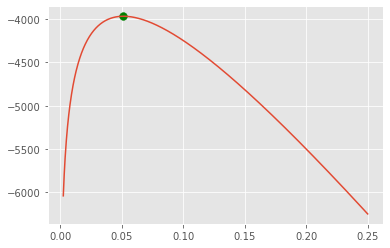

In [58]:
l = np.linspace(0.0025, 0.25, 1000)
lh = lnL(l, x)

plt.plot(l, -lh)
plt.scatter(res.x[0], -lnL(res.x[0], x), color='green', s=60, marker='o');

__Построим для параметра $\lambda$ асимптотический $80\%$ доверительный интервал__ 

In [60]:
lambda_hat = res.x[0]
alpha = 0.2
z = stats.norm.ppf(1-alpha/2)

left = lambda_hat-z*np.sqrt(res.hess_inv[0])
right = lambda_hat+z*np.sqrt(res.hess_inv[0])

left, right, z

(array([0.0484675]), array([0.05435962]), 1.2815515655446004)

In [61]:
assert np.abs(z - 1.2815) < 1e-4

# несколько похожих скрытых тестов

__Проверим на уровне значимости $1\%$ тестом отношения правдоподобия гипотезу__ о том, что $\lambda = 0.05$. 

In [72]:
def lnL_ur(theta, x):
    x = np.array(x)
    n = x.size
    l_ur = n*np.log(theta) - theta*np.sum(x)
    
    return -l_ur

def lnL_r(theta, x):
    x = np.array(x)
    n = x.size
    l_r = n*np.log(0.05) - 0.05*np.sum(x)
    
    return -l_r

In [73]:
theta_init = 0.05
res_ur = minimize(lnL_ur, theta_init, args=x)
res_r = minimize(lnL_r, theta_init, args=x)

In [74]:
res_ur

      fun: 3967.853186205376
 hess_inv: array([[5.28459964e-06]])
      jac: array([-3.05175781e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 14
      nit: 4
     njev: 7
   status: 2
  success: False
        x: array([0.05141356])

In [78]:
lnL_un = res_ur.fun
lnL_r = res_r.fun

# наблюдаемое значение статистики
LR_obs =  2*(lnL_r - lnL_un) 

# критическое значение
LR_cr = stats.chi2(df=1).ppf(0.99)

In [79]:
assert np.abs(lnL_un - 3967.8531) < 1e-4

# несколько похожих скрытых тестов

## Логистическая регрессия и ММП

Оценим методом максимального правдоподобия логистическую регрессию.

$28$ января $1986$ года космический шатл «Челленджер» взорвался при взлёте. Семь астронавтов, находившихся на борту, погибли. В ходе расследования причин катастрофы основной версией была неполадка с резиновыми уплотнительными кольцами в соединении с ракетными ускорителями. Для $23$ предшествовавших катастрофе полётов «Челленджера» известны температура воздуха и появление повреждений хотя бы у одного из уплотнительных колец.

In [80]:
df = pd.read_csv('challenger.csv', sep=',')
print(df.shape)
df.head()

(23, 3)


,Date,Temperature,Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
3,01/11/1982,68,0
4,04/04/1983,67,0


__а)__ Постройте на графиках гистограмму для распределения температуры $(Temperature)$ в ситуациях, когда хотябы одно кольцо было повреждено $(Incident = 1)$ и в ситуациях, когда ни одного повреждения не было $(Incident = 0)$. 

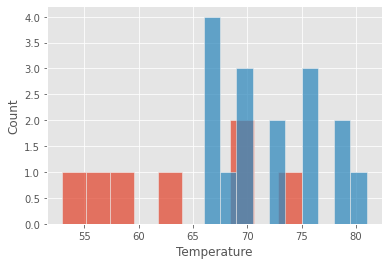

In [90]:
sns.histplot(df[df['Incident']== 1]['Temperature'], bins = 10)
sns.histplot(df[df['Incident']== 0]['Temperature'], bins = 10);

In [91]:
df[df['Incident'] == 1].Temperature.mean(), df[df['Incident'] == 0].Temperature.mean()

(63.714285714285715, 72.125)

Судя по всему, между температурой и вероятностью поломки есть взаимосвязь. Пусть вероятность поломки зависит от температуры экспоненциально:
    
$$
P(Incident = 1) = \frac{e^{\alpha + \beta \cdot t}}{1 + e^{\alpha + \beta \cdot t}} = \frac{1}{1 + e^{-1\cdot(\alpha + \beta \cdot t)}} 
$$
    
Выведем __функцию правдоподобия и задачу для оптимизации поиска коэффициентов $\alpha$ и  $\beta$__

In [153]:
from math import prod

def lnL(theta, data):
    a, b = theta # alpha & beta
    t = np.array(data.Temperature) # массив с данными о температуре (параметр, влияющий на вероятность поломки)
    p = 1 / (1 + np.exp(-(a + b*t))) # вероятности в зависимости от значения температуры
    y = np.array(data.Incident) # индикатор поломки (1 - случилась поломка, 0 - не случилась)
    s = (p**y)*((1-p)**(1-y)) 
    # вектор "частичек" правдоподобия, вероятности получить в распределении бернулли значения индикаторов
    l = np.log(prod(s)) # логарифм правдоподобия (логарифм произведения)
    return -l

In [137]:
assert np.abs(lnL([4, 0.2], df) - 294.8) < 1e-4

# несколько похожих скрытых тестов

__Оценим параметры $\alpha$ и $\beta$__ с помощью метода максимального правдоподобия.

In [154]:
theta_init = [0,0]
res = minimize(lnL, theta_init, args=df)
res

      fun: 10.157596343998065
 hess_inv: array([[ 5.33781132e+01, -7.80341770e-01],
       [-7.80341770e-01,  1.14738253e-02]])
      jac: array([-4.76837158e-07, -2.92062759e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 144
      nit: 14
     njev: 44
   status: 2
  success: False
        x: array([15.04298512, -0.23216397])

In [134]:
res.x # altha & beta MLE

array([15.04298512, -0.23216397])

In [135]:
assert np.abs(res.fun - 10.1576) < 1e-4

# несколько похожих скрытых тестов

С помощью теста отношения правдоподобий на уровне значимости $5\%$ __проверим гипотезу__ о том, что $\alpha = \beta = 0$.

In [151]:
def lnL_r(theta, data):
    a, b = [0,0] # alpha & beta
    t = np.array(data.Temperature) # массив с данными о температуре (параметр, влияющий на вероятность поломки)
    p = 1 / (1 + np.exp(-(a + b*t))) # вероятности в зависимости от значения температуры
    y = np.array(data.Incident) # индикатор поломки (1 - случилась поломка, 0 - не случилась)
    s = (p**y)*((1-p)**(1-y)) 
    # вектор "частичек" правдоподобия, вероятности получить в распределении бернулли значения индикаторов
    l = np.log(prod(s)) # логарифм правдоподобия (логарифм произведения)
    return -l

In [158]:
# второй вариант, в качестве р - подставляем 1/2 (вероятность поломки никак не зависит от температуры и всегда равна 0.5)
def lnL_r(theta, data):
    x = np.array(data.Incident)
    n = x.size
    l = np.sum(x)*np.log(0.5)+(n-np.sum(x))*np.log((1-0.5))
    return -l

In [159]:
theta_init = [0,0]
res_r = minimize(lnL_r, theta_init, args=df)
res_r

      fun: 15.942385152878742
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])

In [160]:
lnL_un = res.fun
lnL_r = res_r.fun

LR_obs = 2*(lnL_r - lnL_un)
LR_crit = stats.chi2(df=2).ppf(0.95)
LR_obs, LR_crit

(11.569577617761354, 5.991464547107979)

> __Вывод:__ гипотеза отвергается, так как наблюдаемое значение статистики превышает критическое. Значит, вероятность поломки зависит определенным образом от температуры. Оптимальные коэффициенты мы нашли методом максимального правдоподобия.

In [ ]:
assert np.abs(lnL_un - 10.1576) < 1e-4

# несколько похожих скрытых тестов

В день катастрофы температура уплотнителя была $31$ градус по Фарингейту. __Предскажем с помощью построенной модели вероятность катастрофы__ (для этого подставим в формулу поиска вероятности получившиеся оценки и температуру).

In [161]:
xnew = 31
alpha, beta = res.x

p_hat = 1 / (1 + np.exp(-(alpha + beta*xnew)))
p_hat

0.9996088006110045

Вероятность катастрофы в таком случае практически единица (в итоге катастрофа и случилась)

In [162]:
assert np.abs(p_hat - 0.9996) < 1e-4

# несколько похожих скрытых тестов

Оценим ту же самую моделю с помощью пакета `statsmodels`.

In [167]:
import statsmodels.formula.api as smf

model = smf.logit(data=df, formula='Incident ~ 1 + Temperature').fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.441635
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Incident   No. Observations:                   23
Model:                          Logit   Df Residuals:                       21
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Nov 2023   Pseudo R-squ.:                  0.2813
Time:                        21:33:13   Log-Likelihood:                -10.158
converged:                       True   LL-Null:                       -14.134
Covariance Type:            nonrobust   LLR p-value:                  0.004804
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      15.0429      7.379      2.039      0.041       0.581      29.505
Temperature    -0.2322      0.108     -2.145      0.032      -0.444      -0.020
===============================================================================
"""

Согласно протоколу: 

- Значение логарифма правдоподобия: `logLik`
- Оценка константы $\alpha$: `alph`
- По свойствам метода максимального правдоподобия $\hat{\beta} \sim N(\beta, \hat{\sigma}^2_{\beta})$, значение $\hat{\sigma}_{\beta}$ равно: `std_beta`
- p-значение для гипотезы $H_0: \beta = 0$: `pval_beta`
- Гипотеза $H_0: \beta = 0$ на $5\%$ уровне значимости отвергается: `is_h` - значение `False`

In [168]:
logLik = -10.158
alph = 15.0429
std_beta = 0.108
pval_beta = 0.032
is_h = False

In [169]:
assert np.abs(logLik + 10.158) < 1e-4

# несколько похожих скрытых тестов